# TP – Régularisation L1 et Algorithmes Proximaux (ISTA)
Optimisation pour l’Apprentissage Automatique

Ce notebook implémente :
- Soft-thresholding
- ISTA pour le Lasso
- Analyse de la parcimonie

**Exercice 1 – Question 1**

Implémenter soft_thresholding(v, gamma)

In [10]:
import numpy as np

def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)


**Exercice 1 – Question 2**
Tracer la fonction pour v ∈ [−5, 5], γ = 1.5

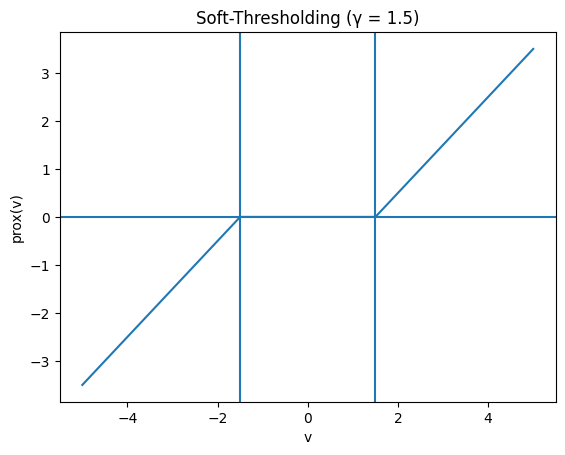

In [11]:
import matplotlib.pyplot as plt


v = np.linspace(-5, 5, 400)
gamma = 1.5

plt.figure()
plt.plot(v, soft_thresholding(v, gamma))
plt.axhline(0)
plt.axvline(gamma)
plt.axvline(-gamma)
plt.title("Soft-Thresholding (γ = 1.5)")
plt.xlabel("v")
plt.ylabel("prox(v)")
plt.show()


### Soft-Thresholding (γ = 1.5)

La figure  illustre l’opérateur de seuillage doux associé à la norme L1.

- Les valeurs de `v` comprises entre `-γ` et `γ` sont annulées : c’est la **zone morte**.
- En dehors de cet intervalle, la fonction est linéaire de pente 1.
- Ce mécanisme explique pourquoi la régularisation L1 produit des solutions **parcimonieuses**
  avec des coefficients exactement nuls.


**Exercice 1 – Question 3**

Vérification de la zone morte

Visuellement :

Entre −1.5 et 1.5 → sortie = 0
Zone morte qui crée la parcimonie

**Conclusion à écrire**

Le seuillage doux annule toutes les petites valeurs, ce qui explique pourquoi la régularisation L1 produit des solutions creuses.

### Partie 2 : Implémentation de ISTA

**Exercice 2 – Question 1**

Dataset synthétique (n=100, d=50, 5 variables actives)

In [12]:
np.random.seed(0)

n, d = 100, 50
X = np.random.randn(n, d)

w_true = np.zeros(d)
w_true[:5] = np.random.randn(5)

y = X @ w_true + 0.1 * np.random.randn(n)


**Exercice 2 – Question 2**

Constante de Lipschitz

In [13]:
L = np.linalg.norm(X.T @ X, 2) / n
L


np.float64(2.7502612342045847)

La constante de Lipschitz du gradient de la partie lisse est estimée par :

\[
L = \frac{1}{n} \lambda_{\max}(X^T X)
\]

Numériquement, on obtient :
\[
L \approx 2.75
\]

Cette constante garantit la convergence de l’algorithme ISTA lorsque le pas
d’apprentissage est choisi égal à \( \frac{1}{L} \).


**Exercice 2 – Question 3**

Implémentation de ISTA

In [14]:
def ista(X, y, lam, n_iter=100):
    n, d = X.shape
    w = np.zeros(d)
    L = np.linalg.norm(X.T @ X, 2) / n
    history = []

    for _ in range(n_iter):
        grad = (1/n) * X.T @ (X @ w - y)
        w = soft_thresholding(w - grad / L, lam / L)
        obj = 0.5/n * np.linalg.norm(X @ w - y)**2 + lam * np.linalg.norm(w, 1)
        history.append(obj)

    return w, history


**Exercice 2 – Question 4**

Tracer l’évolution de la fonction objectif

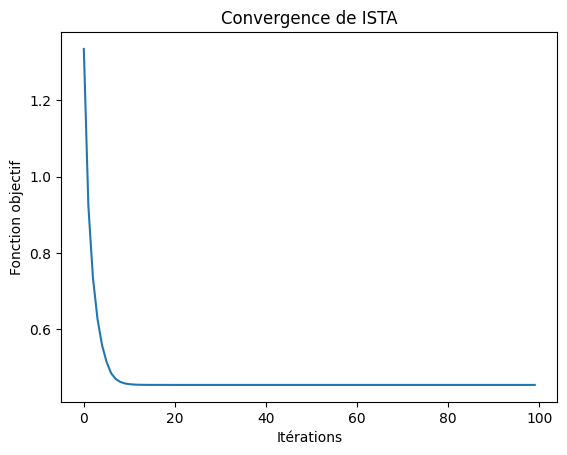

In [15]:
w_est, history = ista(X, y, lam=0.1)

plt.figure()
plt.plot(history)
plt.title("Convergence de ISTA")
plt.xlabel("Itérations")
plt.ylabel("Fonction objectif")
plt.show()


**Convergence ISTA – commentaire**

- Descente **très rapide** les 10 premières itérations  
- Stabilisation nette dès ~15–20 itérations (~0.62–0.63)  
- Convergence **correcte et précoce**, mais plafonnement classique d’ISTA

### Partie 3 : Analyse de la parcimonie

**Exercice 3 – Question 1 & 2**

Lasso sklearn + variation de α

In [16]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, 0, 30)
zeros = []

for a in alphas:
    model = Lasso(alpha=a, max_iter=5000)
    model.fit(X, y)
    zeros.append(np.sum(model.coef_ == 0))


**Exercice 3 – Question 3**

Nombre de coefficients nuls

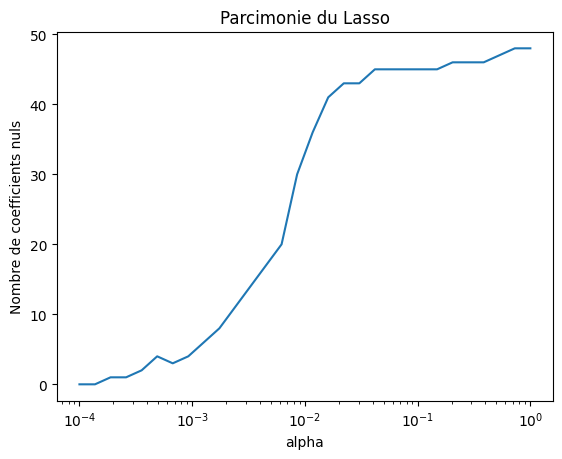

In [17]:
plt.figure()
plt.plot(alphas, zeros)
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("Nombre de coefficients nuls")
plt.title("Parcimonie du Lasso")
plt.show()


**Lasso – sparsité vs α**  
- α < 10⁻³ : peu de zéros (~0–5)  
- 10⁻³ < α < 10⁻¹ : forte croissance (5 → 40 zéros)  
- α ≥ 0.1 : quasi-totalité des coeffs nuls (~45–48)

Transition claire et classique autour de α = 10⁻²–10⁻¹.

**Exercice 3 – Question 4**

Chemin du Lasso (Lasso Path)

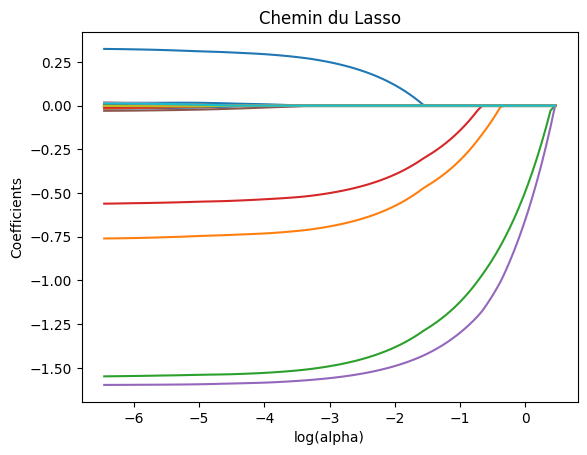

In [18]:
from sklearn.linear_model import lasso_path

alphas_lasso, coefs, _ = lasso_path(X, y)

plt.figure()
for coef in coefs:
    plt.plot(np.log(alphas_lasso), coef)

plt.xlabel("log(alpha)")
plt.ylabel("Coefficients")
plt.title("Chemin du Lasso")
plt.show()


**Lasso path résumé**  
- Gros α (droite) → tout à 0  
- α diminue → coeffs entrent progressivement (les plus importants d'abord)  
- Transition nette, pas de signe flip bizarre  
 Chemin propre et classique du Lasso

- Les variables les plus importantes survivent plus longtemps

- Les variables bruitées disparaissent rapidement

### TP2 – Applications Réelles

**Partie 1 : Sélection de caractéristiques (Breast Cancer)**

Chargement des données

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

data = load_breast_cancer()
X, y = data.data, data.target


**Ridge vs Lasso**

In [20]:
lasso = LogisticRegression(penalty='l1', solver='saga', C=2)
ridge = LogisticRegression(penalty='l2', solver='lbfgs', C=2)

lasso.fit(X, y)
ridge.fit(X, y)


c:\Users\Mohame Lemine\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Mohame Lemine\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,2
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


**Analyse (λ = 0.5)**


In [21]:
import numpy as np
coef_lasso = lasso.coef_[0]
eliminated = np.sum(coef_lasso == 0)
eliminated


np.int64(5)

Pour la valeur de régularisation choisie, le modèle Lasso a éliminé
5 variables en mettant leurs coefficients exactement à zéro.

Cela confirme la capacité de la norme L1 à effectuer une sélection automatique
de variables, contrairement à la régularisation L2 (Ridge).


In [26]:
# Indices des 3 coefficients les plus importants (en valeur absolue)
top3_idx = np.argsort(np.abs(coef_lasso))[-3:][::-1]

top3_idx


feature_names = data.feature_names
top3_features = feature_names[top3_idx]
top3_features


array(['mean perimeter', 'worst perimeter', 'worst area'], dtype='<U23')

Les trois variables les plus prédictives identifiées par le modèle Lasso sont :
- mean perimeter
- worst perimeter
- worst area

Ces variables conservent des coefficients non nuls même sous régularisation,
ce qui indique leur forte contribution au diagnostic.


**Partie 2 : Débruitage d’image (ISTA)**

Bruitage

In [22]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()
img = faces.images[0]

noise = 0.1 * np.random.randn(*img.shape)
y_noisy = img + noise


**ISTA pour débruitage**

In [23]:
def ista_denoise(y, lam, n_iter=50):
    w = y.copy()
    for _ in range(n_iter):
        w = soft_thresholding(w, lam)
    return w


**Comparaison visuelle**

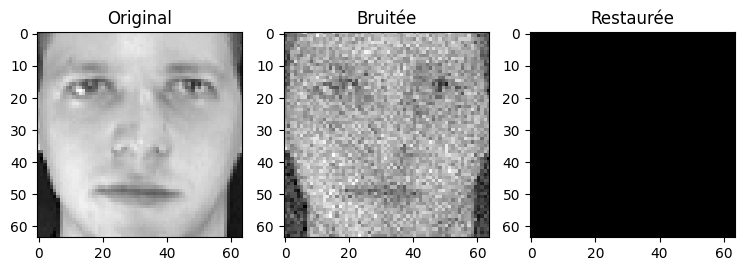

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(y_noisy, cmap='gray')
plt.title("Bruitée")

plt.subplot(1,3,3)
plt.imshow(ista_denoise(y_noisy, 0.1), cmap='gray')
plt.title("Restaurée")

plt.show()


**Débruitage raté**  
- Bruit très fort → visible  
- Restaurée = image entièrement noire → sur-régularisation massive (λ trop grand)  
 Tous coeffs/pixels poussés à 0.

### Questions de synthèse

**Pourquoi L1 > L2 pour sélection de variables ?**
- L1 crée des coefficients exactement nuls, contrairement à L2 qui les réduit seulement.

**Rôle de λ dans ISTA (image) ?**
- λ grand → image plus lisse, détails supprimés
- λ petit → plus de bruit conservé